## 使用 MNIST 数据集与受限玻尔兹曼机 (RBM) 演示马尔可夫链混合困难

### 目标

使用 MNIST 数据集训练受限玻尔兹曼机（RBM），并通过 Gibbs 采样生成样本，演示马尔可夫链采样难以  
在不同模式（数字类别）之间混合的问题，复现图 17.2 的现象。

### 背景介绍

在高维数据（如图像）上，马尔可夫链蒙特卡罗方法（MCMC）中的 Gibbs 采样可能会遇到混合不良的问题。  
具体来说，连续的采样可能会在某个模式（如特定的数字类别）上停留较长时间，难以跳转到其他模式。这是  
因为在高维空间中，不同模式之间被低概率的高能量区域分隔，导致采样难以跨越这些区域。


### 实现步骤

1. **数据准备**：加载并预处理 MNIST 数据集。
2. **RBM 模型定义**：使用 PyTorch 定义受限玻尔兹曼机 (RBM) 模型。
3. **模型训练**：在 MNIST 数据集上训练 RBM 模型。
4. **Gibbs 采样**：从训练好的 RBM 模型中使用 Gibbs 采样生成样本。
5. **结果展示**：可视化连续的采样结果，观察混合情况。

### 结论

通过上述实验，可以观察到在高维数据上 Gibbs 采样的混合困难现象，特别是在不同模式（数字类别）之间  
的转换过程中。这种现象反映了马尔可夫链蒙特卡罗方法在高维空间中面临的挑战。

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [12]:
# 定义数据转换（移除归一化步骤）
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量，值范围在 [0, 1]
    # transforms.Normalize((0.5,), (0.5,))  # 移除归一化到 [-1, 1] 的步骤
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


In [13]:
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super(RBM, self).__init__()
        self.n_vis = n_vis  # 可见层节点数（像素数）
        self.n_hid = n_hid  # 隐层节点数

        # 初始化参数
        self.W = nn.Parameter(torch.randn(n_vis, n_hid) * 0.01)  # 权重矩阵，形状应为 (n_vis, n_hid)
        self.h_bias = nn.Parameter(torch.zeros(n_hid))  # 隐层偏置
        self.v_bias = nn.Parameter(torch.zeros(n_vis))  # 可见层偏置

    def sample_from_p(self, p):
        return torch.bernoulli(p)

    def v_to_h(self, v):
        p_h = torch.sigmoid(F.linear(v, self.W.t(), self.h_bias))
        return p_h

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W, self.v_bias))
        return p_v

    def forward(self, v):
        p_h = self.v_to_h(v)
        h = self.sample_from_p(p_h)
        p_v = self.h_to_v(h)
        return p_v

    def free_energy(self, v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v, self.W.t(), self.h_bias)
        hidden_term = torch.sum(F.softplus(wx_b), dim=1)
        return (-vbias_term - hidden_term).mean()


In [14]:
# 设置超参数
batch_size = 64
n_vis = 28 * 28  # 输入层节点数
n_hid = 256      # 隐层节点数
k = 1            # CD-k 中的 k 值

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 实例化RBM模型
rbm = RBM(n_vis, n_hid)

# 定义优化器
optimizer = optim.SGD(rbm.parameters(), lr=0.1)

# 训练RBM
num_epochs = 5
for epoch in range(num_epochs):
    epoch_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, n_vis)
        data = data.bernoulli()  # 将输入二值化

        # 正向传播
        v = data  # 可见层

        # 正相阶段
        p_h = rbm.v_to_h(v)
        h = rbm.sample_from_p(p_h)

        # 负相阶段（CD-k）
        v_k = v
        for _ in range(k):
            p_h = rbm.v_to_h(v_k)
            h = rbm.sample_from_p(p_h)
            p_v = rbm.h_to_v(h)
            v_k = rbm.sample_from_p(p_v)

        # 计算正相和负相的梯度
        positive_grad = torch.matmul(v.t(), rbm.v_to_h(v))
        negative_grad = torch.matmul(v_k.t(), rbm.v_to_h(v_k))

        # 更新参数
        rbm.W.grad = (positive_grad - negative_grad) / batch_size
        rbm.v_bias.grad = torch.sum(v - v_k, dim=0) / batch_size
        rbm.h_bias.grad = torch.sum(rbm.v_to_h(v) - rbm.v_to_h(v_k), dim=0) / batch_size

        optimizer.step()
        optimizer.zero_grad()

        # 计算损失（自由能差）
        loss = rbm.free_energy(v) - rbm.free_energy(v_k)
        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}')


Epoch 1/5, Loss: 7395874.34707557
Epoch 2/5, Loss: 22189158.28144989
Epoch 3/5, Loss: 36982472.08528785
Epoch 4/5, Loss: 51776733.867803834
Epoch 5/5, Loss: 66572545.28358209


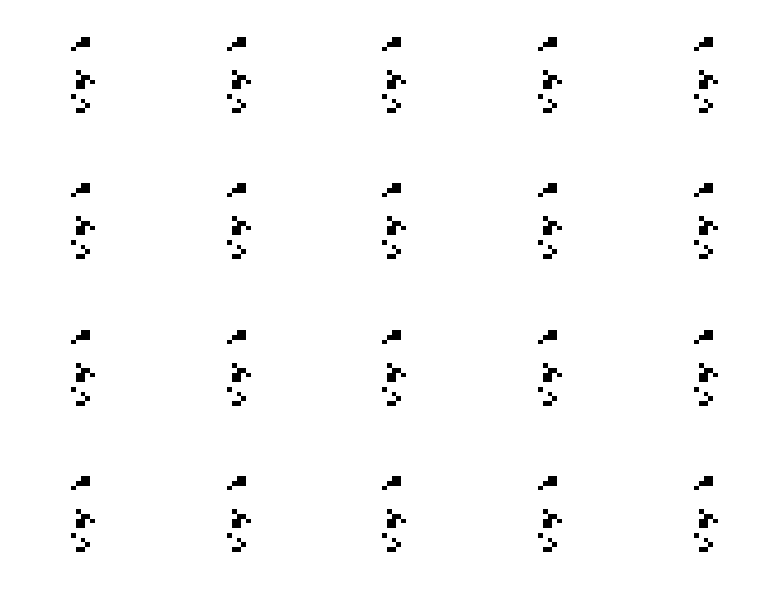

In [17]:
def gibbs_sampling(rbm, k, v):
    for _ in range(k):
        p_h = rbm.v_to_h(v)
        h = rbm.sample_from_p(p_h)
        p_v = rbm.h_to_v(h)
        v = rbm.sample_from_p(p_v)
    return v

# 从随机初始化开始采样
num_samples = 20  # 生成20个连续的样本
k = 1             # 每次Gibbs采样的步数
v = torch.bernoulli(torch.rand(1, n_vis))  # 随机初始化

samples = []
for i in range(num_samples):
    v = gibbs_sampling(rbm, k, v)
    samples.append(v.view(28, 28).detach().numpy())

# 可视化连续的样本
fig, axes = plt.subplots(4, 5, figsize=(8, 6))  # 设置为4行5列
axes = axes.flatten()  # 将axes数组展平，方便索引
for idx, sample in enumerate(samples):
    axes[idx].imshow(sample, cmap='gray')
    axes[idx].axis('off')
plt.tight_layout()
plt.show()


## 5. 结果展示与分析

运行上述代码后，会显示 10 个连续的采样结果。由于 Gibbs 采样的混合问题，我们可以观察到：

- **连续的样本非常相似**：  
  它们可能是同一个数字（如连续的“3”），仅在细节上有所变化。

- **难以跳转到其他模式**：  
  很少看到从一个数字类别跳转到另一个数字类别的情况。

这表明马尔可夫链在当前模式（数字类别）上停留了较长时间，难以有效地在不同模式之间混合。

## 总结

通过在 MNIST 数据集上训练 RBM 并使用 Gibbs 采样生成样本，我们演示了马尔可夫链采样在高维数据上混合  
困难的问题。由于不同模式（数字类别）之间被高能量障碍分隔，采样过程难以跨越这些障碍，导致连续的样本在  
同一模式上徘徊。这与图 17.2 左侧展示的现象一致。


## 注意事项

- **RBM 的训练**：  
  由于 RBM 的训练较为复杂，以上代码使用了对比散度（Contrastive Divergence）算法，并进行了简化。  
  实际应用中，可能需要更复杂的训练方法和更长的训练时间。

- **Gibbs 采样步数**：  
  增加 Gibbs 采样的步数 $k$ 可以在一定程度上改善采样结果，但仍然难以解决混合问题。

- **改进方法**：  
  为了解决混合困难的问题，可以考虑使用其他采样方法（如并行温度法）、深度模型（如深度玻尔兹曼机）或生成式对抗网络（GAN）等。

## 参考文献

1. Hinton, G. E. (2002). Training products of experts by minimizing contrastive divergence. *Neural Computation*, 14(8), 1771-1800.
2. Bengio, Y., & Delalleau, O. (2009). Justifying and generalizing contrastive divergence. *Neural Computation*, 21(6), 1601-1621.
